# **Primera aproximación | Módulo de NLI con LLM (Llama2-1B,3B) cuantizado sin LoRA**. Sin Information Retrieval

## Instalation de paquetes para COLAB

In [44]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [111]:
import gc

gc.collect()

436

In [112]:
torch.cuda.empty_cache()

Con bitsandbytes en un entorno Cuda, he ejecutado:
- !pip install --upgrade "transformers>=4.45.1" --quiet
- !pip install intel_extension_for_pytorch --quiet
- !pip install -U bitsandbytes --quiet
- !pip uninstall -y torch torchvision torchaudio numpy --quiet
- !pip install torch torchvision torchaudio numpy==1.26.4 --quiet # Evitar conflictos con NumPy 2.2.3
- !pip install --upgrade accelerate

In [1]:
%pip install --upgrade "transformers>=4.45.1" --quiet # Es necesario esta version para entorno cuda con cuantizacion (en colab)
%pip install intel_extension_for_pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 MB 8.2 MB/s eta 0:00:00


In [2]:
%pip install -U bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00


In [3]:
%pip uninstall -y torch torchvision torchaudio numpy --quiet
%pip install torch torchvision torchaudio numpy==1.26.4 --quiet # Evitar conflictos con NumPy 2.2.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.3 MB/s eta 0:00:00


In [4]:
%pip install --upgrade accelerate --quiet #deepspeed

In [5]:
!pip install -U FlagEmbedding[finetune] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.5 MB/s eta 0:00

## 📃 Código

### Imports

In [1]:
!nvidia-smi

Wed Apr 23 11:55:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:15:00.0 Off |                    0 |
|  0%   42C    P0              60W / 300W |      3MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Setting up the device for GPU usage
import torch
from torch import cuda
import json
import time
from huggingface_hub import list_datasets
from datasets import load_dataset
from datasets import Dataset, DownloadConfig
from torch.utils.data import Dataset, DataLoader
import sys
import pandas as pd

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")



Number of GPUs available: 6
GPU 0: NVIDIA RTX 4500 Ada Generation
GPU 1: NVIDIA RTX 4500 Ada Generation
GPU 2: NVIDIA A40
GPU 3: NVIDIA GeForce RTX 3090
GPU 4: NVIDIA GeForce RTX 3090
GPU 5: NVIDIA GeForce RTX 3090


In [10]:
device = torch.device(f'cuda:2')

In [11]:
torch.cuda.get_device_name(device)

'NVIDIA A40'

In [12]:
print(f"Usando GPU: {device}")


Usando GPU: cuda:2


### Import Data from HuggingFace repository
We import training set for LoRA and val set from the following link: https://huggingface.co/datasets/JORGEDC01/Demo1


In [5]:
%pip install datasets --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
datasets = list_datasets(author="JORGEDC01")

print([d.id for d in datasets])

In [9]:
!ping huggingface.co

zsh:1: command not found: ping


In [ ]:
data_files = {"train": "e_train_distractors_LoRA_50k.jsonl", "val": "e_val_distractors_LoRA_split.jsonl", "test": "e_test_distractors_LoRA_split.jsonl"}

dataset = load_dataset("JORGEDC01/Demo1", data_dir="LoRA_Data/Distractors", data_files=data_files)
print(dataset)

train_dataset = dataset['train']
val_dataset = dataset['val']
test_dataset = dataset['test']

df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)
df_test = pd.DataFrame(test_dataset)

In [ ]:
df_train.head(2)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit")

In [11]:
decoder = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-1B-bnb-4bit",
)
decoder = decoder.to(device)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


### CustomDataset
We'll prepare the dataset combining the embeddings generated by BGE. There are two types of labels:

* When label = `SUPPORTS`, then: label = 0
* When label = `REFUSES`, then: label = 1
* When label = `NOT ENOUGH INFO`, then: label = 2

In [3]:
from datasets import load_dataset
import pandas as pd

data_files = {
    "train": "../data/e_train_distractors_LoRA_50k.jsonl",
    "val": "../data/e_val_distractors_LoRA_split.jsonl",
    "test": "../data/e_test_distractors_LoRA_split.jsonl"
}

dataset = load_dataset("json", data_files=data_files)

print(dataset)

train_dataset = dataset['train']
val_dataset = dataset['val']
test_dataset = dataset['test']

df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)
df_test = pd.DataFrame(test_dataset)

print(df_train.head())

DatasetDict({
    train: Dataset({
        features: ['verifiable', 'label', 'claim', 'claim_embedding', 'evidence', 'distractors'],
        num_rows: 50907
    })
    val: Dataset({
        features: ['verifiable', 'label', 'claim', 'claim_embedding', 'evidence', 'distractors'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['verifiable', 'label', 'claim', 'claim_embedding', 'evidence', 'distractors'],
        num_rows: 9998
    })
})
       verifiable            label  \
0      VERIFIABLE          REFUTES   
1      VERIFIABLE         SUPPORTS   
2  NOT VERIFIABLE  NOT ENOUGH INFO   
3      VERIFIABLE          REFUTES   
4  NOT VERIFIABLE  NOT ENOUGH INFO   

                                               claim  \
0                          Haitian Creole is a book.   
1  Loving tells the story of the 1967 U.S. Suprem...   
2               Wyatt Earp took part in printmaking.   
3  Azerbaijan lacks a high rate of economic devel...   
4  The Hermetic Order of the

##### Custom Dataset Complejo

In [4]:
class CustomDatasetComplejo(Dataset):
    def __init__(self, df, tokenizer, device):
        self.df = df
        self.tokenizer = tokenizer
        self.targets = self.df['label']
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        ### Obtener embeddings precalculados
        emb_claim = torch.tensor(row['claim_embedding'], dtype=torch.float16).unsqueeze(0).to(self.device)  # (1, 384)
        emds_evidences = [torch.tensor(e, dtype=torch.float16).unsqueeze(0).to(self.device) for e in row['evidence']]
        filtered_evidences = [e for e in emds_evidences if e.shape == (1, 384)]
        embs_distractors = [torch.tensor(d, dtype=torch.float16).unsqueeze(0).to(self.device) for d in row['distractors']]

        encoder_bge_embeddings = torch.cat([emb_claim] + filtered_evidences + embs_distractors, dim=0).unsqueeze(0).to(self.device)  # (1, n, 384)

        label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
        label = torch.tensor(label_map[row['label']], dtype=torch.long).to(self.device)

        attention_mask = torch.ones(1, encoder_bge_embeddings.shape[1], dtype=torch.long, device=self.device)

        inputs = {
            "inputs_embeds": encoder_bge_embeddings,
            "attention_mask": attention_mask,
            "label": label,
        }

        return inputs


from torch.nn.utils.rnn import pad_sequence


def custom_collate_fn_complejo(batch):
    max_input_len = max(item['inputs_embeds'].size(1) for item in batch)  # Longitud máxima de inputs_embeds en el batch

    pad_token_embed = torch.zeros((1, 384), dtype=torch.float16).to(batch[0]['inputs_embeds'].device)  # Padding de ceros con tamaño 384

    padded_inputs = []
    padded_attention_mask = []
    labels = []

    for item in batch:
        ### Padding a los inputs_embeds hasta la longitud máxima (384 ya que no estamos proyectando)
        current_len = item['inputs_embeds'].size(1)
        padding_length = max_input_len - current_len
        if padding_length > 0:
            padding_embeds = pad_token_embed.expand(1, padding_length, -1)  # Expande el padding
            padded_emb = torch.cat([item['inputs_embeds'], padding_embeds], dim=1)
        else:
            padded_emb = item['inputs_embeds']  # Sin padding

        padded_inputs.append(padded_emb)

        ### Padding a la attention_mask
        padded_attention = torch.cat([item['attention_mask'], torch.zeros(1, padding_length, dtype=torch.long, device=item['attention_mask'].device)], dim=1)
        padded_attention_mask.append(padded_attention)

        ### Guardar labels
        labels.append(item['label'])

    inputs_embeds = torch.cat(padded_inputs, dim=0)  # [batch_size, max_seq_len, embedding_dim]
    attention_mask = torch.cat(padded_attention_mask, dim=0)  # [batch_size, max_seq_len]
    labels = torch.tensor(labels, dtype=torch.long, device=inputs_embeds.device)  # [batch_size]

    return {
        'inputs_embeds': inputs_embeds,
        'attention_mask': attention_mask,
        'labels': labels,
    }


In [5]:
def inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params):
    
    train_dataset = CustomDatasetComplejo(df_train, tokenizer, device)
    val_dataset = CustomDatasetComplejo(df_val, tokenizer, device)
    test_dataset = CustomDatasetComplejo(df_test, tokenizer, device)
    
    train_params = params
    
    val_params = params
    
    test_params = params
    
    training_loader = DataLoader(train_dataset, **train_params, collate_fn = custom_collate_fn_complejo)
    val_loader = DataLoader(val_dataset, **val_params, collate_fn = custom_collate_fn_complejo)
    test_loader = DataLoader(test_dataset, **test_params, collate_fn = custom_collate_fn_complejo)

    return training_loader, val_loader, test_loader

#### Modelo

**Primer modelo**: el siguiente modelo que usa la representación CLS no evoluciona. ¡Queda descartado!

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Este modelo que utiliza la representacion del CLS no progresa
class Llama2Classifier_1(nn.Module):
    def __init__(self, decoder, num_classes=3):
        super(Llama2Classifier_1, self).__init__()

        self.size_encoder_embds = 384  # Tamaño original de los embeddings contextuales
        self.size_llm_embds = 2048     # Tamaño de los embeddings proyectados
        self.num_classes = num_classes # Número de clases de salida
        self.decoder = decoder
        self.decoder = self.decoder.to(device)

        # Capa de proyección lineal de 384 a 2048 (como en el modelo Llama2_1B)
        self.linear_projection = nn.Linear(self.size_encoder_embds, self.size_llm_embds)  
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.size_llm_embds, num_classes)  # Capa final de clasificación

    def forward(self, inputs_embeds, attention_mask):
        batch_size = inputs_embeds.size(0)
        encoder_embeds = [] 

        # (1) Proyección de los embeddings contextuales
        encoder_embeds = inputs_embeds  # Usamos los inputs_embeds tal cual están
        
        encoder_embeds = encoder_embeds.to(torch.float32)
            
        # proyección de los embeddings contextuales a un tamaño de 2048
        projected_embeds = self.linear_projection(encoder_embeds)  # Proyección lineal
        projected_embeds = projected_embeds.to(torch.float32)

        attention_mask = attention_mask.to(device).to(torch.float32)
        
        decoder_output = self.decoder(
            inputs_embeds=projected_embeds,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        # embedding correspondiente al token [CLS] o equivalente en LLaMA
        pooled_output = decoder_output.hidden_states[-1][:, 0, :]  # Tomar la primera posición como la representación
        pooled_output = pooled_output.to(torch.float32)

        logits = self.classifier(self.dropout(pooled_output))
        return logits  # Logits para la clasificación (dim: [batch_size, num_classes])


## 
---

## **Experimentos**

In [6]:
loss = torch.nn.CrossEntropyLoss()

def loss_fn(outputs, targets):
    targets = targets.long()  # Asegurar que los targets sean enteros
    return loss(outputs, targets)

### **Experimentos iniciales**

#### 👉 **1º Experimento. Comparación del rendimiento de Llama2 importado de AutoModelForCausalLM y de AutoModelForSequenceClassification**

La idea es comparar el modelo AutoModelForSequenceClassification con el AutoModelForCausalLM.

*Las métricas de este experimento no persisten en ningún json*

> train

In [15]:
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def save_experiment(model_n, description, hyperparams, metrics, test_metrics, confusion_matrix, best_epoch, total_duration):
    experiment = {
        "id": model_n,
        "description": description,
        "hyperparameters": hyperparams,
        "metrics": metrics,
        "test_metrics": test_metrics,
        "confusion_matrix": confusion_matrix.tolist(),
        "best_epoch": best_epoch,
        "time_train": total_duration
    }
    
    try:
        with open("./initial_experiments_noLoRA.json", "r") as f:
            experiments = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        experiments = []
    
    experiments.append(experiment)
    
    with open("./initial_experiments_noLoRA.json", "w") as f:
        json.dump(experiments, f, indent=4)



''' -------------------------------------------------------------------------  '''
''' -------------------------------------------------------------------------  '''
''' -------------------------------------------------------------------------  '''

def evaluate_test(model, test_loader, best_model_path):
    
    state_dict = torch.load(best_model_path, map_location=device)
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
    model.load_state_dict(filtered_state_dict, strict=False)
    
    model.eval()
    
    all_preds, all_labels = [], []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)
            labels = data['labels'].to(device).long()
            
            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    test_metrics = {"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}

    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return test_metrics, cm
    


''' -------------------------------------------------------------------------  '''
''' -------------------------------------------------------------------------  '''
''' -------------------------------------------------------------------------  '''

def train(epochs, model, training_loader, val_loader, optimizer, learning_rate, batch_size, dropout, patience=3, model_n=0, description=""):
    model.train()
    model.to(device)  
    
    batches = len(training_loader)
    scaler = GradScaler()
    
    metrics = {"train": [], "val": []}
    total_start_time = time.time()
    best_val_loss = float('inf')
    best_model_path = f"./Models/noLoRA_best_model_{model_n}.pth"
    no_improve_epochs = 0
        
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        epoch_start_time = time.time()

        for i, data in enumerate(training_loader, 0):
            
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)
            labels = data['labels'].to(device).long()
    
            optimizer.zero_grad()
            
            for param in model.parameters():
                if param.requires_grad:
                    param.data = param.data.to(torch.float32)
                    if param.grad is not None:
                        param.grad.data = param.grad.data.to(torch.float32)
    
            logits = model(inputs_embeds, attention_mask)
            loss = loss_fn(logits, labels)
    
            scaler.scale(loss).backward() # multiplica la pérdida por un factor de escala interno del GradScaler. Cuando trabajamos con float16, los gradientes pueden volverse muy pequeños (subdesbordamiento, es decir, se redondean a 0).
            scaler.unscale_(optimizer)    # Dado que scaler.scale(loss).backward() generó gradientes escalados, esta línea revierte el escalado. Si no se desescala, los gradientes serían demasiado grandes y la actualización del optimizador sería incorrecta.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Esto ayuda a evitar la explosión de gradientes, un problema donde los gradientes se vuelven tan grandes que la actualización de pesos se vuelve inestable.
            scaler.step(optimizer) 
            scaler.update()
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        train_loss = total_loss / batches
        train_acc = total_correct / total_samples
        
        # Evaluación
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for data in val_loader:
                inputs_embeds = data['inputs_embeds'].to(device)
                attention_mask = data['attention_mask'].to(device).to(torch.float32)
                labels = data['labels'].to(device).long()
                
                logits = model(inputs_embeds, attention_mask)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        
        epoch_duration = (time.time() - epoch_start_time) / 60
        print(f"Epoch {epoch+1}/{epochs} | tr_loss: {train_loss:.4f}, tr_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {acc:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        
        metrics["train"].append({"epoch": epoch+1, "loss": train_loss, "accuracy": train_acc})
        metrics["val"].append({"epoch": epoch+1, "loss": val_loss, "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)
            no_improve_epochs = 0  # Reset counter
        else:
            no_improve_epochs += 1
        
        # Early stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. No improvement in validation loss for {patience} consecutive epochs.")
            break
    
    total_duration = (time.time() - total_start_time) / 60  
    print(f"Total training time: {total_duration:.2f} min")
    
    test_metrics, cm = evaluate_test(model, test_loader, best_model_path)
    hyperparams = {"epochs": epochs, "optimizer": str(optimizer), "learning_rate": learning_rate, "batch_size": batch_size, "dropout": dropout, "patience": patience}
    save_experiment(model_n, description, hyperparams, metrics, test_metrics, cm, best_epoch, total_duration)

##### Con AutoModelForCausalLM
- Decoder con AutoModelForCausalLM
- Learning rate de 1e-4

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Llama2Classifier_2(nn.Module):
    def __init__(self, decoder, num_classes=3):
        super(Llama2Classifier_2, self).__init__()

        self.size_encoder_embds = 384  # Tamaño original de los embeddings contextuales
        self.size_llm_embds = 2048     # Tamaño de los embeddings proyectados
        self.num_classes = num_classes # Número de clases de salida
        self.decoder = decoder
        self.decoder = self.decoder.to(device)

        # Capa de proyección lineal de 384 a 2048 (como en el modelo Llama2_1B)
        self.linear_projection = nn.Linear(self.size_encoder_embds, self.size_llm_embds)  
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.size_llm_embds, num_classes)  # Capa final de clasificación

    def forward(self, inputs_embeds, attention_mask):
        batch_size = inputs_embeds.size(0)
        encoder_embeds = [] 

        # (1) Proyección de los embeddings contextuales
        encoder_embeds = inputs_embeds  # Usamos los inputs_embeds tal cual están
        
        encoder_embeds = encoder_embeds.to(torch.float32)
            
        # proyección de los embeddings contextuales a un tamaño de 2048
        projected_embeds = self.linear_projection(encoder_embeds)  # Proyección lineal
        projected_embeds = projected_embeds.to(torch.float32)

        attention_mask = attention_mask.to(device).to(torch.float32)
        
        decoder_output = self.decoder(
            inputs_embeds=projected_embeds,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        hidden_states = decoder_output.hidden_states  
        last_hidden_state = hidden_states[-1] # la última capa de hidden states

        # Agregar las salidas a través de la secuencia (puedes usar promedio o sumatoria)
        aggregated_output = torch.sum(last_hidden_state, dim=1)  # Promedio las salidas

        logits = self.classifier(self.dropout(aggregated_output))
        return logits  # Logits para la clasificación (dim: [batch_size, num_classes])

In [20]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

params = {'batch_size': 256, 'shuffle': True, 'num_workers': 0}
training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)

decoder = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit",)
decoder = decoder.to(device)

model = Llama2Classifier_2(decoder, num_classes=3)
model = model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-4)

train(10, model, training_loader, val_loader, optimizer, patience=6, model_n=1)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Epoch 1/10 | tr_loss: 2.9519, tr_acc: 0.5131, val_loss: 1.5554, val_acc: 0.6022, Prec: 0.7180, Recall: 0.6022, F1-score: 0.5882
Epoch 2/10 | tr_loss: 0.8692, tr_acc: 0.7168, val_loss: 0.8790, val_acc: 0.6533, Prec: 0.7426, Recall: 0.6533, F1-score: 0.6350
Epoch 3/10 | tr_loss: 0.7729, tr_acc: 0.7448, val_loss: 0.7509, val_acc: 0.6803, Prec: 0.7308, Recall: 0.6803, F1-score: 0.6683
Epoch 4/10 | tr_loss: 0.6880, tr_acc: 0.7571, val_loss: 0.7585, val_acc: 0.6884, Prec: 0.7622, Recall: 0.6884, F1-score: 0.6696
Epoch 5/10 | tr_loss: 0.5725, tr_acc: 0.7971, val_loss: 0.7063, val_acc: 0.7234, Prec: 0.7709, Recall: 0.7234, F1-score: 0.7021
Epoch 6/10 | tr_loss: 0.5371, tr_acc: 0.8012, val_loss: 0.9188, val_acc: 0.6195, Prec: 0.7448, Recall: 0.6195, F1-score: 0.6118
Epoch 7/10 | tr_loss: 0.5081, tr_acc: 0.8093, val_loss: 0.7105, val_acc: 0.7297, Prec: 0.7731, Recall: 0.7297, F1-score: 0.7084
Epoch 8/10 | tr_loss: 0.4745, tr_acc: 0.8253, val_loss: 0.6482, val_acc: 0.7393, Prec: 0.7580, Recall: 0

Test Accuracy: 0.7139, Precision: 0.7565, Recall: 0.7139, F1-score: 0.6890


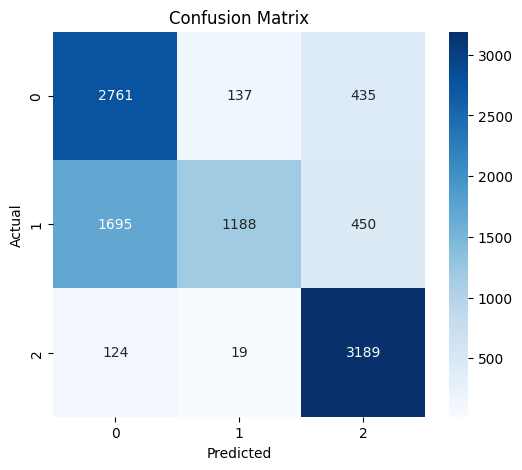

In [21]:
evaluate_test(model, test_loader)

##### Con AutoModelForSequenceClassification
- Decoder importado de AutoModelForSequenceClassification
- Learning rate de 1e-4.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification

class Llama2Classifier_3(nn.Module):
    def __init__(self, num_classes=3):
        super(Llama2Classifier_3, self).__init__()
        self.size_encoder_embds = 384   # Tamaño original de los embeddings contextuales
        self.size_llm_embds = 2048      # Tamaño de los embeddings proyectados
        self.num_classes = num_classes  # Número de clases de salida
        self.model = AutoModelForSequenceClassification.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit", num_labels=num_classes)
        self.model = self.model.to(device)
        self.linear_projection = nn.Linear(self.size_encoder_embds, self.size_llm_embds)  

    def forward(self, inputs_embeds, attention_mask):

        encoder_embeds = inputs_embeds  # Usamos los inputs_embeds tal cual están
        encoder_embeds = encoder_embeds.to(torch.float32)
            
        projected_embeds = self.linear_projection(encoder_embeds)  # Proyección lineal
        projected_embeds = projected_embeds.to(torch.float32)

        attention_mask = attention_mask.to(device).to(torch.float32)
        
        attention_mask = attention_mask.to(device).to(torch.float32)
        outputs = self.model(inputs_embeds=projected_embeds, attention_mask=attention_mask)
        logits = outputs.logits  # Obtener los logits directamente
        return logits  # Logits para la clasificación (dim: [batch_size, num_classes])


In [27]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

params = {'batch_size': 256, 'shuffle': True, 'num_workers': 0}
training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)

model = Llama2Classifier_3(num_classes=3)
model = model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-4)

train(10, model, training_loader, val_loader, optimizer, patience=6)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at unsloth/Llama-3.2-1B-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | tr_loss: 0.6402, tr_acc: 0.7462, val_loss: 0.6606, val_acc: 0.7215, Prec: 0.7688, Recall: 0.7215, F1-score: 0.7030
Epoch 2/10 | tr_loss: 0.4373, tr_acc: 0.8317, val_loss: 0.5940, val_acc: 0.7453, Prec: 0.7670, Recall: 0.7453, F1-score: 0.7318
Epoch 3/10 | tr_loss: 0.3678, tr_acc: 0.8531, val_loss: 0.6280, val_acc: 0.7409, Prec: 0.7742, Recall: 0.7409, F1-score: 0.7263
Epoch 4/10 | tr_loss: 0.3139, tr_acc: 0.8758, val_loss: 0.6200, val_acc: 0.7501, Prec: 0.7668, Recall: 0.7501, F1-score: 0.7400
Epoch 5/10 | tr_loss: 0.2664, tr_acc: 0.8954, val_loss: 0.6878, val_acc: 0.7422, Prec: 0.7646, Recall: 0.7422, F1-score: 0.7298
Epoch 6/10 | tr_loss: 0.2249, tr_acc: 0.9123, val_loss: 0.7323, val_acc: 0.7449, Prec: 0.7617, Recall: 0.7449, F1-score: 0.7333
Epoch 7/10 | tr_loss: 0.1850, tr_acc: 0.9298, val_loss: 0.7443, val_acc: 0.7513, Prec: 0.7561, Recall: 0.7513, F1-score: 0.7416
Epoch 8/10 | tr_loss: 0.1487, tr_acc: 0.9463, val_loss: 0.8372, val_acc: 0.7372, Prec: 0.7590, Recall: 0

Test Accuracy: 0.7199, Precision: 0.7462, Recall: 0.7199, F1-score: 0.7055


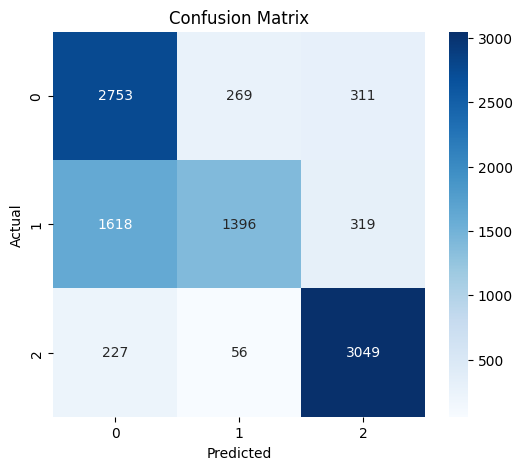

In [30]:
evaluate_test(model, test_loader)

#### 👉 2º Experimento. Modelado Exploratorio de Llama2 importado desde AutoModelForCausalLM (Adam y AdamW)

Se comparan los resultados usando dos optimizadores diferentes, para evaluar si la elección de algunos hiperparámetros es clave en el entrenamiento del modelo, cuyo decoder es importado desde AutoModelForCausalLM.

In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

experiments = [
    {"lr": 5e-5, "dropout": 0.4, "batch_size": 128, "optimizer": "Adam"},  
    {"lr": 3e-5, "dropout": 0.3, "batch_size": 256, "optimizer": "AdamW"}  
]

optimizers = {
    "Adam": lambda model, lr: torch.optim.Adam(model.parameters(), lr=lr),
    "AdamW": lambda model, lr: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
}

for i, exp in enumerate(experiments, start=3):  

    params = {'batch_size': exp["batch_size"], 'shuffle': True, 'num_workers': 0}
    training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)
    
    model = Llama2Classifier_2(decoder, num_classes=3).to(device)
    optimizer = optimizers[exp["optimizer"]](model, exp["lr"])
    
    train(
        epochs=20,  
        model=model,
        training_loader=training_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        learning_rate=exp["lr"],
        batch_size=exp["batch_size"],
        dropout=exp["dropout"],
        patience=5,
        model_n=i,
        description=f"Exp {i}: Optimizer={exp['optimizer']}, lr={exp['lr']}, dropout={exp['dropout']}, batch_size={exp['batch_size']}",
    )



Training Log for Exp 3: Optimizer=Adam, lr=5e-05, dropout=0.4, batch_size=128
Epoch 1/9 | tr_loss: 3.4693, tr_acc: 0.5930, val_loss: 1.8053, val_acc: 0.6916, Prec: 0.7583, Recall: 0.6916, F1-score: 0.6732
Epoch 2/9 | tr_loss: 0.6147, tr_acc: 0.7890, val_loss: 0.7829, val_acc: 0.7071, Prec: 0.7659, Recall: 0.7071, F1-score: 0.6829
Epoch 3/9 | tr_loss: 0.5082, tr_acc: 0.8128, val_loss: 0.7512, val_acc: 0.7215, Prec: 0.7719, Recall: 0.7215, F1-score: 0.6989
Epoch 4/9 | tr_loss: 0.4585, tr_acc: 0.8288, val_loss: 0.6226, val_acc: 0.7421, Prec: 0.7591, Recall: 0.7421, F1-score: 0.7358
Epoch 5/9 | tr_loss: 0.4134, tr_acc: 0.8434, val_loss: 0.6670, val_acc: 0.7469, Prec: 0.7422, Recall: 0.7469, F1-score: 0.7383
Epoch 6/9 | tr_loss: 0.3872, tr_acc: 0.8502, val_loss: 0.7282, val_acc: 0.7242, Prec: 0.7734, Recall: 0.7242, F1-score: 0.7154
Epoch 7/9 | tr_loss: 0.3496, tr_acc: 0.8644, val_loss: 0.6944, val_acc: 0.7532, Prec: 0.7712, Recall: 0.7532, F1-score: 0.7443
Epoch 8/9 | tr_loss: 0.3172, tr_

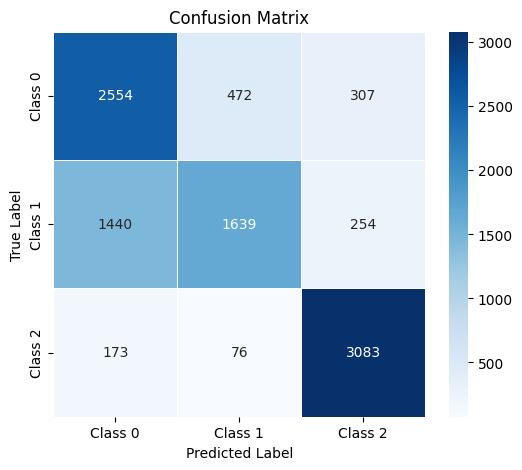


Training Log for Exp 4: Optimizer=AdamW, lr=3e-05, dropout=0.3, batch_size=256
Epoch 1/17 | tr_loss: 3.9961, tr_acc: 0.4452, val_loss: 1.6097, val_acc: 0.5082, Prec: 0.4560, Recall: 0.5082, F1-score: 0.4167
Epoch 2/17 | tr_loss: 0.7884, tr_acc: 0.7004, val_loss: 0.7956, val_acc: 0.6644, Prec: 0.7164, Recall: 0.6644, F1-score: 0.6442
Epoch 3/17 | tr_loss: 0.6457, tr_acc: 0.7652, val_loss: 0.7027, val_acc: 0.7016, Prec: 0.7335, Recall: 0.7016, F1-score: 0.6893
Epoch 4/17 | tr_loss: 0.6073, tr_acc: 0.7811, val_loss: 0.7776, val_acc: 0.6965, Prec: 0.7713, Recall: 0.6965, F1-score: 0.6709
Epoch 5/17 | tr_loss: 0.5482, tr_acc: 0.7968, val_loss: 0.6365, val_acc: 0.7250, Prec: 0.7436, Recall: 0.7250, F1-score: 0.7162
Epoch 6/17 | tr_loss: 0.5207, tr_acc: 0.8072, val_loss: 0.6917, val_acc: 0.7137, Prec: 0.7710, Recall: 0.7137, F1-score: 0.6990
Epoch 7/17 | tr_loss: 0.4912, tr_acc: 0.8144, val_loss: 0.6968, val_acc: 0.7169, Prec: 0.7795, Recall: 0.7169, F1-score: 0.6968
Epoch 8/17 | tr_loss: 0.

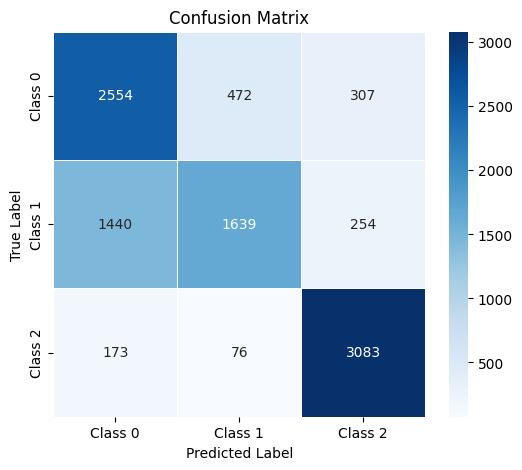

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_experiment_results(filepath):
    with open(filepath, "r") as f:
        experiments = json.load(f)
    return experiments

def print_training_log(experiment):
    print(f"\nTraining Log for {experiment['description']}")
    
    train_metrics = experiment["metrics"]["train"]
    val_metrics = experiment["metrics"]["val"]
    
    for epoch_data in train_metrics:
        epoch = epoch_data["epoch"]
        train_loss = epoch_data["loss"]
        train_acc = epoch_data["accuracy"]
        
        val_data = next((v for v in val_metrics if v["epoch"] == epoch), None)
        if val_data:
            val_loss = val_data["loss"]
            val_acc = val_data["accuracy"]
            precision = val_data.get("precision", 0)
            recall = val_data.get("recall", 0)
            f1 = val_data.get("f1_score", 0)

            print(f"Epoch {epoch}/{len(train_metrics)} | "
                  f"tr_loss: {train_loss:.4f}, tr_acc: {train_acc:.4f}, "
                  f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, "
                  f"Prec: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    print(f"Early stopping triggered after {experiment['best_epoch']} epochs.")
    print(f"Total training time: {experiment['time_train']}")
    print(f"Test Accuracy: {experiment['test_metrics']['accuracy']:.4f}, "
          f"Precision: {experiment['test_metrics']['precision']:.4f}, "
          f"Recall: {experiment['test_metrics']['recall']:.4f}, "
          f"F1-score: {experiment['test_metrics']['f1_score']:.4f}")


def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], 
                yticklabels=["Class 0", "Class 1", "Class 2"], linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


filepath = "./initial_experiments_noLoRA.json"
experiments = load_experiment_results(filepath)

print_training_log(experiments[0])

conf_matrix = np.array(last_experiment['confusion_matrix'])
plot_confusion_matrix(conf_matrix)

print_training_log(experiments[1])

conf_matrix = np.array(last_experiment['confusion_matrix'])
plot_confusion_matrix(conf_matrix)


### ⚡ **Experimentos con varios modelos de la familia Llama-2**

En este apartado, se prueban diversos tamaños de Llama. Cada modelo se evalua en **3 ejecuciones**.
Los decoder-only de Llama2 se importan desde *AutoModelForCausalLM*

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Llama2Classifier_2(nn.Module):
    def __init__(self, decoder, emb_size, num_classes=3):
        super(Llama2Classifier_2, self).__init__()

        self.size_encoder_embds = 384      # Tamaño original de los embeddings contextuales
        self.size_llm_embds = emb_size     # Tamaño de los embeddings proyectados
        self.num_classes = num_classes     # Número de clases de salida
        self.decoder = decoder
        self.decoder = self.decoder.to(device)

        # Capa de proyección lineal de 384 a 2048 (como en el modelo Llama2_1B)
        self.linear_projection = nn.Linear(self.size_encoder_embds, self.size_llm_embds)  
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.size_llm_embds, num_classes)  # Capa final de clasificación

    def forward(self, inputs_embeds, attention_mask):
        batch_size = inputs_embeds.size(0)
        encoder_embeds = [] 

        # (1) Proyección de los embeddings contextuales
        encoder_embeds = inputs_embeds  # Usamos los inputs_embeds tal cual están
        
        encoder_embeds = encoder_embeds.to(torch.float32)
            
        # proyección de los embeddings contextuales a un tamaño de 2048
        projected_embeds = self.linear_projection(encoder_embeds)  # Proyección lineal
        projected_embeds = projected_embeds.to(torch.float32)

        attention_mask = attention_mask.to(device).to(torch.float32)
        
        decoder_output = self.decoder(
            inputs_embeds=projected_embeds,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        hidden_states = decoder_output.hidden_states  
        last_hidden_state = hidden_states[-1] # la última capa de hidden states

        # Agregar las salidas a través de la secuencia (puedes usar promedio o sumatoria)
        aggregated_output = torch.sum(last_hidden_state, dim=1)  # Promedio las salidas

        logits = self.classifier(self.dropout(aggregated_output))
        return logits  # Logits para la clasificación (dim: [batch_size, num_classes])

In [8]:
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import torch


def model_builder(decoder_name, emb_size, lr):

    decoder = AutoModelForCausalLM.from_pretrained(model_name, num_labels=3)
    model = Llama2Classifier_2(decoder, emb_size, num_classes=3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2, betas=(0.9, 0.95))
    return model, optimizer

''' -------------------------------------------------------------------------------- '''    
def run_experiments(n_experiments, model_builder, decoder_name, llm_name, emb_size, model_n_start, description_base, training_loader, val_loader, test_loader, learning_rate, batch_size, dropout, patience, experiment):
    all_metrics = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "time_train": []
    }

    experiment_results = []  # Lista para los resultados de cada experimento
    
    model_experiments = []  # Lista para almacenar los mejores modelos de cada experimento

    best_model = None
    best_f1_score = -float('inf')  # Mejor pérdida de validación
    best_model_path = ""

    for i in range(n_experiments):
        print(f"\n\n[*** Experimento {i+1}/{n_experiments}] -----------------------------")

        model_n = model_n_start + i
        description = f"{description_base} | Run {i+1}/{n_experiments}"

        model, optimizer = model_builder(decoder_name, emb_size, learning_rate)
        
        # Entrenamiento del modelo
        hyperparams, metrics, test_metrics, cm, best_epoch, total_duration, path = train(
                                                                                    epochs=15, 
                                                                                    model=model,
                                                                                    training_loader=training_loader,
                                                                                    val_loader=val_loader,
                                                                                    optimizer=optimizer,
                                                                                    learning_rate=learning_rate,
                                                                                    batch_size=batch_size,
                                                                                    dropout=dropout,
                                                                                    patience=patience,
                                                                                    model_n=model_n,
                                                                                    description=description,
                                                                                    experiment=experiment
                                                                                )

        model_experiments.append(path)
        test = test_metrics  # Asumimos que test_metrics es un diccionario con las métricas de test

        all_metrics["accuracy"].append(test["accuracy"])
        all_metrics["precision"].append(test["precision"])
        all_metrics["recall"].append(test["recall"])
        all_metrics["f1_score"].append(test["f1_score"])
        all_metrics["time_train"].append(total_duration)

        f1_score = test["f1_score"]

        if f1_score > best_f1_score:  # Si el modelo actual tiene mejor F1-score
            best_f1_score = f1_score
            best_model = model
            best_model_path = f"./Models/exp({experiment})_noLoRA_best_model_{model_n}.pth"  # Ruta para este modelo
            best_experiment = {
                "id": model_n,
                "description": description,
                "hyperparameters": hyperparams,
                "metrics": metrics,
                "test_metrics": test_metrics,
                "confusion_matrix": cm.tolist(),
                "best_epoch": best_epoch,
                "time_train": total_duration
            }

    # Eliminacion de los n - 1 modelos peores respecto al mejor
    for path in model_experiments:
        if path != best_model_path:
            try:
                os.remove(path)
                print(f"Modelo eliminado: {path}")
            except FileNotFoundError:
                print(f"[Aviso] No se encontró el archivo para eliminar: {path}")

    
    print(f"\n --- Evaluación del mejor modelo: {best_model_path}")
    print(f"Test Accuracy:  {best_experiment['test_metrics']['accuracy']:.4f}")
    print(f"Test Precision: {best_experiment['test_metrics']['precision']:.4f}")
    print(f"Test Recall:    {best_experiment['test_metrics']['recall']:.4f}")
    print(f"Test F1-score:  {best_experiment['test_metrics']['f1_score']:.4f}")

    print(f"\n --- Matriz de confusión del mejor modelo: ")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
    # Métricas agregadas
    print("\n[*** Resultados Finales]")
    for metric in all_metrics:
        values = np.array(all_metrics[metric])
        print(f"{metric.capitalize()}: Media = {values.mean():.4f} | Std = {values.std():.4f}")

    # Guardado de todos los experimentos en un archivo JSON
    experiment_data = {
        "id_experiment": f"experiment_{experiment}",  # ID único para el experimento grande
        "llm_name": llm_name,
        "best_experiment": best_experiment,
        "aggregated_metrics": {
            "accuracy_mean": np.mean(all_metrics["accuracy"]),
            "accuracy_std": np.std(all_metrics["accuracy"]),
            "precision_mean": np.mean(all_metrics["precision"]),
            "precision_std": np.std(all_metrics["precision"]),
            "recall_mean": np.mean(all_metrics["recall"]),
            "recall_std": np.std(all_metrics["recall"]),
            "f1_score_mean": np.mean(all_metrics["f1_score"]),
            "f1_score_std": np.std(all_metrics["f1_score"]),
            "time_train_mean": np.mean(all_metrics["time_train"]),
            "time_train_std": np.std(all_metrics["time_train"])
        },
        "best_model_path": best_model_path  # Lista con los mejores modelos de cada experimento
    }

    try:
        with open("./diverse_llama2_noLoRA.json", "r") as f:
            all_experiments = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        all_experiments = []

    all_experiments.append(experiment_data)

    with open("./diverse_llama2_noLoRA.json", "w") as f:
        json.dump(all_experiments, f, indent=4)




''' -------------------------------------------------------------------------------- '''
def evaluate_test(model, test_loader, best_model_path, show_cm=None):
    state_dict = torch.load(best_model_path, map_location=device)
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
    model.load_state_dict(filtered_state_dict, strict=False)
    
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)
            labels = data['labels'].to(device).long()
            
            logits = model(inputs_embeds, attention_mask)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    test_metrics = {"accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}

    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    if show_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    return test_metrics, cm


''' -------------------------------------------------------------------------------- '''
def train(epochs, model, training_loader, val_loader, optimizer, learning_rate, batch_size, dropout, patience=3, model_n=0, description="", experiment=""):
    model.train()
    model.to(device)  
    
    batches = len(training_loader)
    scaler = GradScaler()
    
    metrics = {"train": [], "val": []}
    total_start_time = time.time()
    best_val_loss = float('inf')
    best_model_path = f"./Models/exp({experiment})_noLoRA_best_model_{model_n}.pth"
    no_improve_epochs = 0
        
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        epoch_start_time = time.time()

        for i, data in enumerate(training_loader, 0):
            
            inputs_embeds = data['inputs_embeds'].to(device)
            attention_mask = data['attention_mask'].to(device).to(torch.float32)
            labels = data['labels'].to(device).long()
    
            optimizer.zero_grad()
            
            for param in model.parameters():
                if param.requires_grad:
                    param.data = param.data.to(torch.float32)
                    if param.grad is not None:
                        param.grad.data = param.grad.data.to(torch.float32)
    
            logits = model(inputs_embeds, attention_mask)
            loss = loss_fn(logits, labels)
    
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer) 
            scaler.update()
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
        
        train_loss = total_loss / batches
        train_acc = total_correct / total_samples
        
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for data in val_loader:
                inputs_embeds = data['inputs_embeds'].to(device)
                attention_mask = data['attention_mask'].to(device).to(torch.float32)
                labels = data['labels'].to(device).long()
                
                logits = model(inputs_embeds, attention_mask)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        
        epoch_duration = (time.time() - epoch_start_time) / 60
        print(f"Epoch {epoch+1}/{epochs} | tr_loss: {train_loss:.4f}, tr_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {acc:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        
        metrics["train"].append({"epoch": epoch+1, "loss": train_loss, "accuracy": train_acc})
        metrics["val"].append({"epoch": epoch+1, "loss": val_loss, "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    
    total_duration = (time.time() - total_start_time) / 60  
    print(f"Total training time: {total_duration:.2f} min")
    
    test_metrics, cm = evaluate_test(model, test_loader, best_model_path, show_cm=False)
    hyperparams = {"epochs": epochs, "optimizer": str(optimizer), "learning_rate": learning_rate, "batch_size": batch_size, "dropout": dropout, "patience": patience}

    return hyperparams, metrics, test_metrics, cm, best_epoch, total_duration, best_model_path


#### 0. **Modelo Llama2-1B-bnb-4bit**
*n_experiments = 3*


🔄 Cargando modelo: unsloth/Llama-3.2-1B-bnb-4bit


`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.




[*** Experimento 1/3] -----------------------------
Epoch 1/15 | tr_loss: 3.8008, tr_acc: 0.4697, val_loss: 1.7780, val_acc: 0.5589, Prec: 0.6527, Recall: 0.5589, F1-score: 0.5410
Epoch 2/15 | tr_loss: 1.0190, tr_acc: 0.6729, val_loss: 0.9825, val_acc: 0.6084, Prec: 0.6857, Recall: 0.6084, F1-score: 0.5954
Epoch 3/15 | tr_loss: 0.8101, tr_acc: 0.7310, val_loss: 0.8549, val_acc: 0.6781, Prec: 0.7220, Recall: 0.6781, F1-score: 0.6563
Epoch 4/15 | tr_loss: 0.6978, tr_acc: 0.7652, val_loss: 0.7510, val_acc: 0.6735, Prec: 0.7278, Recall: 0.6735, F1-score: 0.6684
Epoch 5/15 | tr_loss: 0.5728, tr_acc: 0.7939, val_loss: 0.7300, val_acc: 0.7045, Prec: 0.7643, Recall: 0.7045, F1-score: 0.6879
Epoch 6/15 | tr_loss: 0.5188, tr_acc: 0.8087, val_loss: 0.6356, val_acc: 0.7444, Prec: 0.7537, Recall: 0.7444, F1-score: 0.7374
Epoch 7/15 | tr_loss: 0.4752, tr_acc: 0.8222, val_loss: 0.6783, val_acc: 0.7305, Prec: 0.7757, Recall: 0.7305, F1-score: 0.7168
Epoch 8/15 | tr_loss: 0.4301, tr_acc: 0.8344, val_

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Epoch 1/15 | tr_loss: 3.6008, tr_acc: 0.4680, val_loss: 1.8483, val_acc: 0.5535, Prec: 0.6354, Recall: 0.5535, F1-score: 0.5229
Epoch 2/15 | tr_loss: 0.8540, tr_acc: 0.7026, val_loss: 1.1372, val_acc: 0.6397, Prec: 0.7275, Recall: 0.6397, F1-score: 0.5899
Epoch 3/15 | tr_loss: 0.6320, tr_acc: 0.7723, val_loss: 0.7189, val_acc: 0.7094, Prec: 0.7591, Recall: 0.7094, F1-score: 0.6872
Epoch 4/15 | tr_loss: 0.5452, tr_acc: 0.8043, val_loss: 0.7094, val_acc: 0.7088, Prec: 0.7788, Recall: 0.7088, F1-score: 0.6867
Epoch 5/15 | tr_loss: 0.4965, tr_acc: 0.8159, val_loss: 0.7519, val_acc: 0.7139, Prec: 0.7729, Recall: 0.7139, F1-score: 0.6895
Epoch 6/15 | tr_loss: 0.4613, tr_acc: 0.8259, val_loss: 0.6303, val_acc: 0.7350, Prec: 0.7665, Recall: 0.7350, F1-score: 0.7216
Epoch 7/15 | tr_loss: 0.4365, tr_acc: 0.8333, val_loss: 0.6429, val_acc: 0.7441, Prec: 0.7736, Recall: 0.7441, F1-score: 0.7234
Epoch 8/15 | tr_loss: 0.4168, tr_acc: 0.8378, val_loss: 0.6502, val_acc: 0.7430, Prec: 0.7877, Recall: 0

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Epoch 1/15 | tr_loss: 3.5198, tr_acc: 0.4696, val_loss: 1.5919, val_acc: 0.6084, Prec: 0.6753, Recall: 0.6084, F1-score: 0.5906
Epoch 2/15 | tr_loss: 0.7915, tr_acc: 0.7148, val_loss: 0.9978, val_acc: 0.6519, Prec: 0.7172, Recall: 0.6519, F1-score: 0.6149
Epoch 3/15 | tr_loss: 0.6815, tr_acc: 0.7681, val_loss: 0.7299, val_acc: 0.7082, Prec: 0.7411, Recall: 0.7082, F1-score: 0.6901
Epoch 4/15 | tr_loss: 0.5966, tr_acc: 0.7939, val_loss: 0.7072, val_acc: 0.7149, Prec: 0.7569, Recall: 0.7149, F1-score: 0.7006
Epoch 5/15 | tr_loss: 0.5753, tr_acc: 0.8012, val_loss: 0.6695, val_acc: 0.7388, Prec: 0.7681, Recall: 0.7388, F1-score: 0.7204
Epoch 6/15 | tr_loss: 0.5125, tr_acc: 0.8179, val_loss: 0.7388, val_acc: 0.7342, Prec: 0.7961, Recall: 0.7342, F1-score: 0.7071
Epoch 7/15 | tr_loss: 0.4706, tr_acc: 0.8298, val_loss: 0.6505, val_acc: 0.7416, Prec: 0.7870, Recall: 0.7416, F1-score: 0.7204
Epoch 8/15 | tr_loss: 0.4417, tr_acc: 0.8347, val_loss: 0.6764, val_acc: 0.7449, Prec: 0.7936, Recall: 0

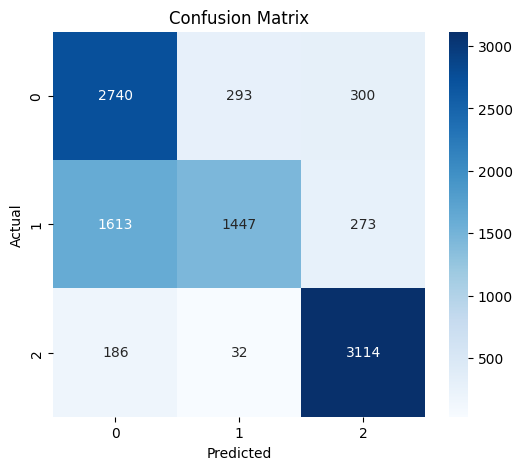


[*** Resultados Finales]
Accuracy: Media = 0.7269 | Std = 0.0035
Precision: Media = 0.7431 | Std = 0.0106
Recall: Media = 0.7269 | Std = 0.0035
F1_score: Media = 0.7152 | Std = 0.0013
Time_train: Media = 39.6872 | Std = 4.3678


In [15]:
import warnings
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
warnings.simplefilter("ignore", category=FutureWarning)

### Decoder Llama2-3.2-1B-bnb-4bit
model_name = "unsloth/Llama-3.2-1B-bnb-4bit"
print(f"\n🔄 Cargando modelo: {model_name}")
emb_size = 2048

tokenizer = AutoTokenizer.from_pretrained(model_name)

decoder = AutoModelForCausalLM.from_pretrained(
    model_name,
    num_labels=3,
)

### Datos
params = {'batch_size': 128, 'shuffle': True, 'num_workers': 0}
training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)

### Experimento
lr = 3e-5
batch_size = 128
dropout = 0.3
n_experiments = 3


run_experiments(
    n_experiments=n_experiments,
    model_builder=model_builder,
    decoder_name=model_name,
    llm_name=model_name,
    emb_size=emb_size,
    model_n_start=10,
    description_base=f"Estudio de diferentes modelos Llama2 sin LoRA. Experimento NoLoRA. Modelo: {model_name} - AdamW, lr={lr}, batch_size={batch_size}, n_experiments={n_experiments}",
    training_loader=training_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    learning_rate=lr,
    batch_size=batch_size,
    dropout=dropout,
    patience=5,
    experiment="Llama-3.2-1B-bnb-4bit"
)

#### 1. **Modelo Llama2-3B-bnb-4bit**



🔄 Cargando modelo: unsloth/Llama-3.2-3B-bnb-4bit


`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.




[*** Experimento 1/3] -----------------------------
Epoch 1/15 | tr_loss: 1.4170, tr_acc: 0.6363, val_loss: 0.7911, val_acc: 0.7215, Prec: 0.7769, Recall: 0.7215, F1-score: 0.7024
Epoch 2/15 | tr_loss: 0.4794, tr_acc: 0.8238, val_loss: 0.5902, val_acc: 0.7494, Prec: 0.7765, Recall: 0.7494, F1-score: 0.7338
Epoch 3/15 | tr_loss: 0.4158, tr_acc: 0.8409, val_loss: 0.5768, val_acc: 0.7520, Prec: 0.7757, Recall: 0.7520, F1-score: 0.7391
Epoch 4/15 | tr_loss: 0.3665, tr_acc: 0.8568, val_loss: 0.6833, val_acc: 0.7396, Prec: 0.8002, Recall: 0.7396, F1-score: 0.7192
Epoch 5/15 | tr_loss: 0.3319, tr_acc: 0.8682, val_loss: 0.6720, val_acc: 0.7512, Prec: 0.7846, Recall: 0.7512, F1-score: 0.7360
Epoch 6/15 | tr_loss: 0.2939, tr_acc: 0.8818, val_loss: 0.8196, val_acc: 0.7407, Prec: 0.7906, Recall: 0.7407, F1-score: 0.7212
Epoch 7/15 | tr_loss: 0.2611, tr_acc: 0.8960, val_loss: 0.7464, val_acc: 0.7526, Prec: 0.7542, Recall: 0.7526, F1-score: 0.7459
Epoch 8/15 | tr_loss: 0.2259, tr_acc: 0.9093, val_

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Epoch 1/15 | tr_loss: 1.3123, tr_acc: 0.6435, val_loss: 0.6968, val_acc: 0.7364, Prec: 0.7616, Recall: 0.7364, F1-score: 0.7191
Epoch 2/15 | tr_loss: 0.4646, tr_acc: 0.8276, val_loss: 0.6131, val_acc: 0.7440, Prec: 0.7890, Recall: 0.7440, F1-score: 0.7301
Epoch 3/15 | tr_loss: 0.4002, tr_acc: 0.8462, val_loss: 0.5468, val_acc: 0.7604, Prec: 0.7708, Recall: 0.7604, F1-score: 0.7535
Epoch 4/15 | tr_loss: 0.3584, tr_acc: 0.8599, val_loss: 0.5697, val_acc: 0.7661, Prec: 0.7842, Recall: 0.7661, F1-score: 0.7557
Epoch 5/15 | tr_loss: 0.3150, tr_acc: 0.8768, val_loss: 0.6690, val_acc: 0.7629, Prec: 0.7805, Recall: 0.7629, F1-score: 0.7497
Epoch 6/15 | tr_loss: 0.2785, tr_acc: 0.8886, val_loss: 0.7070, val_acc: 0.7625, Prec: 0.7771, Recall: 0.7625, F1-score: 0.7533
Epoch 7/15 | tr_loss: 0.2421, tr_acc: 0.9058, val_loss: 0.7486, val_acc: 0.7580, Prec: 0.7632, Recall: 0.7580, F1-score: 0.7522
Epoch 8/15 | tr_loss: 0.2055, tr_acc: 0.9193, val_loss: 0.9661, val_acc: 0.7552, Prec: 0.7704, Recall: 0

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Epoch 1/15 | tr_loss: 1.5941, tr_acc: 0.6006, val_loss: 0.9796, val_acc: 0.6858, Prec: 0.7810, Recall: 0.6858, F1-score: 0.6675
Epoch 2/15 | tr_loss: 0.4839, tr_acc: 0.8218, val_loss: 0.6604, val_acc: 0.7434, Prec: 0.7899, Recall: 0.7434, F1-score: 0.7196
Epoch 3/15 | tr_loss: 0.4078, tr_acc: 0.8421, val_loss: 0.6083, val_acc: 0.7541, Prec: 0.7853, Recall: 0.7541, F1-score: 0.7354
Epoch 4/15 | tr_loss: 0.3655, tr_acc: 0.8572, val_loss: 0.6730, val_acc: 0.7383, Prec: 0.7975, Recall: 0.7383, F1-score: 0.7182
Epoch 5/15 | tr_loss: 0.3262, tr_acc: 0.8708, val_loss: 0.7840, val_acc: 0.7519, Prec: 0.7871, Recall: 0.7519, F1-score: 0.7308
Epoch 6/15 | tr_loss: 0.2852, tr_acc: 0.8862, val_loss: 0.7800, val_acc: 0.7580, Prec: 0.7851, Recall: 0.7580, F1-score: 0.7428
Epoch 7/15 | tr_loss: 0.2474, tr_acc: 0.9021, val_loss: 0.7616, val_acc: 0.7539, Prec: 0.7737, Recall: 0.7539, F1-score: 0.7452
Epoch 8/15 | tr_loss: 0.2094, tr_acc: 0.9169, val_loss: 0.8422, val_acc: 0.7510, Prec: 0.7610, Recall: 0

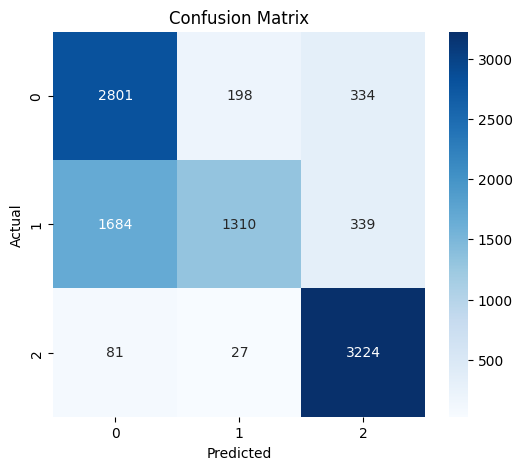


[*** Resultados Finales]
Accuracy: Media = 0.7373 | Std = 0.0057
Precision: Media = 0.7602 | Std = 0.0037
Recall: Media = 0.7373 | Std = 0.0057
F1_score: Media = 0.7225 | Std = 0.0106
Time_train: Media = 57.6671 | Std = 0.0752


In [17]:
import warnings
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
warnings.simplefilter("ignore", category=FutureWarning)

### Decoder Llama2-3.2-3B-bnb-4bit
model_name = "unsloth/Llama-3.2-3B-bnb-4bit"
print(f"\n🔄 Cargando modelo: {model_name}")
emb_size = 3072

tokenizer = AutoTokenizer.from_pretrained(model_name)

decoder = AutoModelForCausalLM.from_pretrained(
    model_name,
    num_labels=3,
)

### Datos
params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}
training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)

### Experimento
lr = 3e-5
batch_size = 64
dropout = 0.3
n_experiments = 3


run_experiments(
    n_experiments=n_experiments,
    model_builder=model_builder,
    decoder_name=model_name,
    llm_name=model_name,
    emb_size=emb_size,
    model_n_start=10,
    description_base=f"Estudio de diferentes modelos Llama2 sin LoRA. Experimento NoLoRA. Modelo: {model_name} - AdamW, lr={lr}, batch_size={batch_size}, n_experiments={n_experiments}",
    training_loader=training_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    learning_rate=lr,
    batch_size=batch_size,
    dropout=dropout,
    patience=5,
    experiment="Llama-3.2-3B-bnb-4bit"
)

#### 2. Modelo Llama2-7B-bnb-4bit

*A partir de modelos con más parámetros, es necesario aplicar LoRA*

In [ ]:
# unsloth/llama-2-7b-bnb-4bit

In [ ]:
import warnings
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
warnings.simplefilter("ignore", category=FutureWarning)

### Decoder Llama2-3.2-3B-bnb-4bit
model_name = "unsloth/llama-2-7b-bnb-4bit"
print(f"\n🔄 Cargando modelo: {model_name}")
emb_size = 4096

tokenizer = AutoTokenizer.from_pretrained(model_name)

decoder = AutoModelForCausalLM.from_pretrained(
    model_name,
    num_labels=3,
)

### Datos
params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}
training_loader, val_loader, test_loader = inicialize_loaders(df_train, df_val, df_test, tokenizer, device, params)

### Experimento
lr = 3e-5
batch_size = 64
dropout = 0.3
n_experiments = 3


run_experiments(
    n_experiments=n_experiments,
    model_builder=model_builder,
    decoder_name=model_name,
    llm_name=model_name,
    emb_size=emb_size,
    model_n_start=13,
    description_base=f"Estudio de diferentes modelos Llama2 sin LoRA. Experimento NoLoRA. Modelo: {model_name} - AdamW, lr={lr}, batch_size={batch_size}, n_experiments={n_experiments}",
    training_loader=training_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    learning_rate=lr,
    batch_size=batch_size,
    dropout=dropout,
    patience=5,
    experiment="Llama-2-7b-bnb-4bit"
)

---
## Arreglo Nans

In [122]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit")
decoder = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-bnb-4bit", device_map="auto").to(device)

encoder_emb_size = 384
decoder_emb_size = 2048

# Proyección de embeddings
projection_layer = nn.Linear(encoder_emb_size, decoder_emb_size).to(device).to(torch.float16)

# Datos de entrada para 3 iteraciones
inputs_data = [
    {"claim": torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16),
     "evidence": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "distractor": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "label": "the evidence supports the claim"},
    {"claim": torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16),
     "evidence": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "distractor": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "label": "the claim is contradicted by the evidence"},
    {"claim": torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16),
     "evidence": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "distractor": [torch.randn(1, encoder_emb_size, device=device, dtype=torch.float16) for _ in range(2)],
     "label": "the claim is neutral with respect to the evidence"}
]

# Optimizador
optimizer = torch.optim.AdamW(decoder.parameters(), lr=5e-5)

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Entrenamiento por 3 iteraciones
for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    total_loss = 0
    
    for i, data in enumerate(inputs_data):
        optimizer.zero_grad()
        
        claim_emb = data["claim"]
        evidence_emb = torch.cat(data["evidence"], dim=0)
        distractor_emb = torch.cat(data["distractor"], dim=0)
        
        encoder_embeddings = torch.cat([claim_emb, evidence_emb, distractor_emb], dim=0)
        projected_embeddings = projection_layer(encoder_embeddings).unsqueeze(0)  # (1, seq_len, 2048)
        
        
        decoder_inputs = tokenizer(data["label"], return_tensors="pt").to(device)
        decoder_input_ids = decoder_inputs.input_ids  # (1, seq_len)
        seq_len = projected_embeddings.shape[1]
        
        
        labels = torch.full((1, seq_len + decoder_input_ids.shape[1] - 1), -100, device=device, dtype=torch.long)
        labels[:, seq_len:] = decoder_input_ids[:, 1:]
        
        token_embeddings = decoder.get_input_embeddings()(decoder_input_ids)  # (1, seq_len, 2048)
        inputs_embeds = torch.cat([projected_embeddings, token_embeddings[:, 1:].to(device)], dim=1)

        for param in decoder.parameters():
            if param.requires_grad:  # Solo los parámetros entrenables
                param.data = param.data.to(torch.float32)
                if param.grad is not None:
                    param.grad.data = param.grad.data.to(torch.float32)
        print(decoder_inputs.attention_mask.dtype)
        # Diccionario de entrada
        inputs = {
            "inputs_embeds": inputs_embeds,
            "attention_mask": decoder_inputs.attention_mask,
            "labels": labels,
        }
        
        # Paso por el modelo
        outputs = decoder(**inputs)
        loss = outputs.loss
        print(f"Batch {i}: {loss}")
            
        # Backpropagation
        scaler.scale(loss).backward() # multiplica la pérdida por un factor de escala interno del GradScaler. Cuando trabajamos con float16, los gradientes pueden volverse muy pequeños (subdesbordamiento, es decir, se redondean a 0).
        scaler.unscale_(optimizer)    # Dado que scaler.scale(loss).backward() generó gradientes escalados, esta línea revierte el escalado. Si no se desescala, los gradientes serían demasiado grandes y la actualización del optimizador sería incorrecta.
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0) # Esto ayuda a evitar la explosión de gradientes, un problema donde los gradientes se vuelven tan grandes que la actualización de pesos se vuelve inestable.
        scaler.step(optimizer) # scaler.step(optimizer) solo ejecuta optimizer.step() si no hubo desbordamiento (overflow) en los gradientes.
        scaler.update()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} Loss: {total_loss / len(inputs_data):.4f}\n")

print("Entrenamiento finalizado.")


/tmp/ipykernel_33686/1006177021.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3
torch.int64
Batch 0: 11.624799728393555
torch.int64
Batch 1: 10.49564266204834
torch.int64
Batch 2: 8.213210105895996
Epoch 1 Loss: 10.1112

Epoch 2/3
torch.int64
Batch 0: 11.561985969543457
torch.int64
Batch 1: 9.517707824707031
torch.int64
Batch 2: 7.436384201049805
Epoch 2 Loss: 9.5054

Epoch 3/3
torch.int64
Batch 0: 10.724608421325684
torch.int64
Batch 1: 8.812566757202148
torch.int64
Batch 2: 6.79634952545166
Epoch 3 Loss: 8.7778

Entrenamiento finalizado.
